In [ ]:
# -*- coding: utf-8 -*-
"""
Postprocessing the grid files to create a ground truth for the inverse problem.
This script creates ground truth data needed for Figure 9 in the UQ chapter.

@author: chloe
"""
#%% Import the modules
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.io as sio
import sys
file_path = '/Users/chloe/Documents/Stanford/ME398_Spring/marsden_uq/uq_mf_chapters/uq_chapter/chap6_inv/circuits'
sys.path.append(file_path) # where rcModel and rcrModel are located
from RC_simulator import RCR_sim

In [ ]:
# %% Choose the QOI for parsing the grid files

n_points = 32

In [ ]:
#%% Load the observation

# The true values should be:
Rp = 1000
C  = 3e-5
Rd = 1000

# load synthetic observation for the RCR model from the paper
cycleTime   = 1.07
totalCycles = 10
p_no_noise  = RCR_sim([Rp, Rd, C], cycleTime, totalCycles)

sigma_noise_min  = p_no_noise[0] * 0.01
sigma_noise_max  = p_no_noise[1] * 0.01
sigma_noise_mean = p_no_noise[2] * 0.01

epsilon = [[np.random.normal(0, sigma_noise_min)], [np.random.normal(0, sigma_noise_max)], [np.random.normal(0, sigma_noise_mean)]]

y_obs = [[p_no_noise[0] + epsilon[0][0]], [p_no_noise[1] + epsilon[1][0]], [p_no_noise[2] + epsilon[2][0]]]

In [ ]:
#%% Create relevant meshgrids for posterior plots

# original [Rp, C, Rd] values
# Rp_orig  = 6.8123e2
# C_orig   = 3.6664e-5
# Rd_orig  = 3.1013e4
Rp_orig = 1000
C_orig  = 3e-5
Rd_orig = 1000

# with corresponding bounds
RCR_bounds_grid = np.array([0.5, 0.5, 0.5])

# # Create linspace of [Rp, C, Rd] values to pull out the first 20 points
Rp_low  = Rp_orig - Rp_orig*RCR_bounds_grid[0]
Rp_high = Rp_orig + Rp_orig*RCR_bounds_grid[0]
Rd_low  = Rd_orig - Rd_orig*RCR_bounds_grid[1]
Rd_high = Rd_orig + Rd_orig*RCR_bounds_grid[1]
C_low   = C_orig - C_orig*RCR_bounds_grid[2]
C_high  = C_orig + C_orig*RCR_bounds_grid[2]

Rp_grid = np.linspace(Rp_low, Rp_high, n_points)
C_grid  = np.linspace(C_low, C_high, n_points)
Rd_grid = np.linspace(Rd_low, Rd_high, n_points)

# Create meshgrid
Rp_mesh, Rd_mesh, C_mesh = np.meshgrid(Rp_grid, Rd_grid, C_grid, indexing='ij')

In [ ]:
#%% Plot posterior distributions

def p_prior(x):
    Rp, Rd, C = x[0][0], x[1][0], x[2][0]
    if  (Rp > Rp_low and Rp < Rp_high) and \
        (C > C_low and C < C_high) and \
        (Rd > Rd_low and Rd < Rd_high):
        p_prior = 1/(Rp_high-Rp_low)/(C_high-C_low)/(Rd_high-Rd_low)
    else:
        p_prior = 0
    return p_prior

def p_likelihood(y):
    cov_matrix           = np.array([[(sigma_noise_min)**2, 0, 0], [0, (sigma_noise_max)**2, 0], [0, 0, (sigma_noise_mean)**2]])
    inv_cov, det_cov, k  = np.linalg.inv(cov_matrix), np.linalg.det(cov_matrix), np.shape(cov_matrix)[0]
    p_likelihood         = (2*np.pi)**(-k/2) * det_cov**(-1/2) * np.exp(-0.5*np.matmul(np.matmul(np.transpose(y-y_obs),inv_cov),y-y_obs))
    return p_likelihood

# construct posterior
P_posterior    = lambda x,y: p_likelihood(y)*p_prior(x)

grid_posterior = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))
grid_prior     = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))

s           = sio.loadmat('./grid_RCR_pressures.mat')
grid_p_min  = s['grid_p_min']
grid_p_max  = s['grid_p_max']
grid_p_mean = s['grid_p_mean']

for i in tqdm(np.arange(Rp_mesh.shape[0])):
    for j in np.arange(Rp_mesh.shape[1]):
        for k in np.arange(Rp_mesh.shape[2]):
            theta = np.array([[Rp_mesh[i,j,k]], [Rd_mesh[i,j,k]], [C_mesh[i,j,k]]])
            grid_posterior[i,j,k] = P_posterior(theta, np.array([[grid_p_min[i,j,k]], [grid_p_max[i,j,k]], [grid_p_mean[i,j,k]]]))
            grid_prior[i,j,k] = p_prior(theta)

posterior = grid_posterior / np.sum(grid_posterior.flatten()*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])*(Rd_grid[1]-Rd_grid[0]))
prior     = grid_prior / np.sum(grid_prior.flatten()*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])*(Rd_grid[1]-Rd_grid[0]))

posterior = np.reshape(posterior, (n_points, n_points, n_points))
prior     = np.reshape(prior, (n_points, n_points, n_points))

  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-5-7b90351c58a1>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grid_posterior[i,j,k] = P_posterior(theta, np.array([[grid_p_min[i,j,k]], [grid_p_max[i,j,k]], [grid_p_mean[i,j,k]]]))
 12%|█▎        | 4/32 [00:00<00:00, 36.91it/s]<ipython-input-5-7b90351c58a1>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grid_posterior[i,j,k] = P_posterior(theta, np.array([[grid_p_min[i,j,k]], [grid_p_max[i,j,k]], [grid_p_mean[i,j,k]]]))
100%|██████████| 32/32 [00:00<00:00, 45.77it/s]


In [ ]:
# %% Compute the marginal distributions

# dim = 1 is Rp, dim = 0 is C, dim = 2 is Rd

# now, Rp, Rd, C

# marginal distributions along 2 dims
marginal_CRd  = np.sum(posterior, axis=1)*(Rp_grid[1]-Rp_grid[0])
marginal_RpRd = np.sum(posterior, axis=2)*(C_grid[1]-C_grid[0])
marginal_CRp  = np.sum(posterior, axis=0)*(Rd_grid[1]-Rd_grid[0])

# marginal distribution along 1 dim
marginal_Rp   = np.sum(posterior, axis=(0,2))*(Rd_grid[1]-Rd_grid[0])*(C_grid[1]-C_grid[0])
marginal_Rd   = np.sum(posterior, axis=(1,2))*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])
marginal_C    = np.sum(posterior, axis=(0,1))*(Rp_grid[1]-Rp_grid[0])*(Rd_grid[1]-Rd_grid[0])

In [ ]:
#%% Compute the prior distributions

# prior distribution along 2 dims
prior_CRd     = np.sum(prior, axis=1)*(Rp_grid[1]-Rp_grid[0])
prior_RpRd    = np.sum(prior, axis=2)*(C_grid[1]-C_grid[0])
prior_CRp     = np.sum(prior, axis=0)*(Rd_grid[1]-Rd_grid[0])

# prior distribution along 1 dim
prior_Rp      = np.sum(prior, axis=(0,2))*(Rd_grid[1]-Rd_grid[0])*(C_grid[1]-C_grid[0])
prior_Rd      = np.sum(prior, axis=(1,2))*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])
prior_C       = np.sum(prior, axis=(0,1))*(Rp_grid[1]-Rp_grid[0])*(Rd_grid[1]-Rd_grid[0])

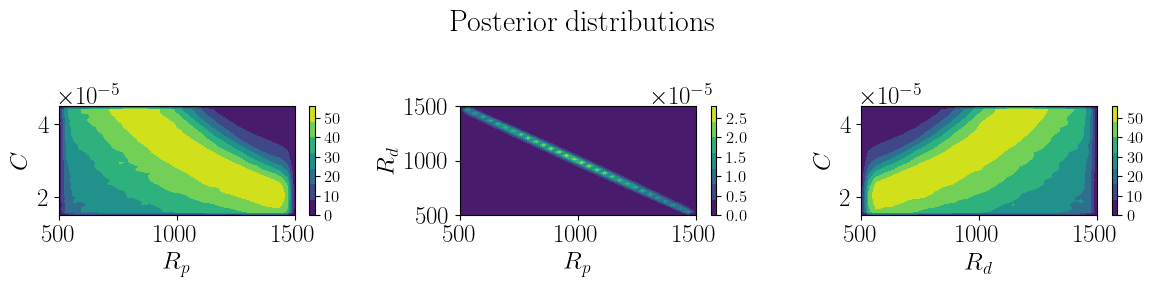

In [ ]:
#%% Plot the posterior distributions for the marginal distributions along 2 dims

# Rp, Rd, C --> Rd, Rp, C

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 18
})

fig, ax = plt.subplots(1, 3, figsize=(12,3), gridspec_kw={'width_ratios': [1, 1, 1],
                                          'height_ratios': [1]})

slice_idx = 0

cbar_a = ax[0].contourf(Rp_grid, C_grid, marginal_CRp.T)
# ax[0].contour(Rp_grid, C_grid, prior_CRp.T, colors='y', linestyles='--')
ax[0].set_xlabel('$R_p$')
ax[0].set_ylabel('$C$')

cbar_b = ax[1].contourf(Rp_grid, Rd_grid, marginal_RpRd)
# ax[1].contour(Rp_grid, Rd_grid, prior_RpRd.T, colors='y', linestyles='--')
ax[1].set_xlabel('$R_p$')
ax[1].set_ylabel('$R_d$')
# ax[1].set_ylim([25000, 28000])
# ax[1].set_xlim([Rp_low, 1000])

cbar_c = ax[2].contourf(Rd_grid, C_grid, marginal_CRd.T)
# ax[2].contour(Rd_grid, C_grid, prior_CRd, colors='y', linestyles='--')
ax[2].set_xlabel('$R_d$')
ax[2].set_ylabel('$C$')
# ax[2].set_ylim([3.5e-5, 5e-5])
# ax[2].set_xlim([25000, 30000])

nbins = 6
cbar = fig.colorbar(cbar_a)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar.locator = tick_locator
cbar.update_ticks()

cbar2 = fig.colorbar(cbar_b)
cbar2.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar2.locator = tick_locator
cbar2.update_ticks()

cbar3 = fig.colorbar(cbar_c)
cbar3.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar3.locator = tick_locator
cbar3.update_ticks()

fig.suptitle('Posterior distributions')

fig.tight_layout()

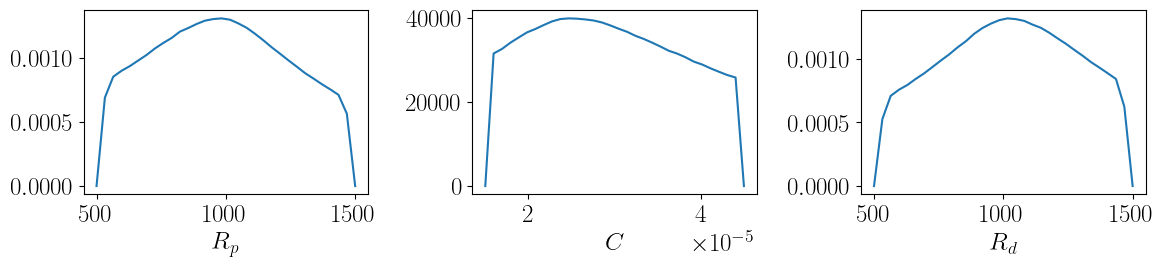

In [ ]:
# %% Plot the one dimensional marginals along 1 dim

fig, ax = plt.subplots(1, 3, figsize=(12,3), gridspec_kw={'width_ratios': [1, 1, 1],
                                          'height_ratios': [1]})

slice_idx = 0

cbar_a = ax[0].plot(Rp_grid, marginal_Rp)
# ax[0].plot(Rp_grid, prior_Rp, 'k--')
ax[0].set_xlabel('$R_p$')
# ax[0].legend(['Posterior', 'Prior'])

cbar_b = ax[1].plot(C_grid, marginal_C)
# ax[1].plot(C_grid, prior_C, 'k--')
# ax[1].legend(['Posterior', 'Prior'])
ax[1].set_xlabel('$C$')

cbar_c = ax[2].plot(Rd_grid, marginal_Rd)
# ax[2].plot(Rd_grid, prior_Rd, 'k--')
# ax[2].legend(['Posterior', 'Prior'])
ax[2].set_xlabel('$R_d$')

fig.tight_layout()

In [ ]:
#%% Save the marginal distributions

# zerod_filepath  = '/Users/chloe/Desktop/grid_0D/'

# zerod_filepath  = './grid_0D/'

# sio.savemat(zerod_filepath+'marginal_CRp.mat', 
#             {'Rp_grid': Rp_grid,
#              'C_grid': C_grid, 
#              'Rd_grid': Rd_grid,
#              'marginal_CRp': marginal_CRp.T.detach().numpy(),
#              'marginal_RpRd': marginal_RpRd.T.detach().numpy(),
#              'marginal_CRd': marginal_CRd.detach().numpy(),
#              'marginal_Rp': marginal_Rp.detach().numpy(),
#              'marginal_C': marginal_C.detach().numpy(),
#              'marginal_Rd': marginal_Rd.detach().numpy(),
#              'prior_CRp': prior_CRp.T.detach().numpy(),
#              'prior_RpRd': prior_RpRd.T.detach().numpy(),
#              'prior_CRd': prior_CRd.detach().numpy(),
#              'prior_Rp': prior_Rp.detach().numpy(),
#              'prior_C': prior_C.detach().numpy(),
#              'prior_Rd': prior_Rd.detach().numpy()})

In [ ]:
# %%

# #%% Construct grid of values

# # construct prior
# #x_mean          = np.array([[Rp_orig],[Rd_orig],[C_orig]])

# def p_prior(x):
#     # p_prior = 1
#     Rp, Rd, C = x[0][0], x[1][0], x[2][0]
#     if  (Rp > Rp_low and Rp < Rp_high) and \
#         (C > C_low and C < C_high) and \
#         (Rd > Rd_low and Rd < Rd_high):
#         p_prior = 1/(Rp_high-Rp_low)/(C_high-C_low)/(Rd_high-Rd_low)
#     else:
#         p_prior = 0
#     # multivariate gaussian
#     # cov_matrix   = np.array([[(Rp_orig/8)**2, 0, 0], [0, (C_orig/8)**2, 0], [0, 0, (Rd_orig/8)**2]])
#     # inv_cov      = np.linalg.inv(cov_matrix)
#     # det_cov      = np.linalg.det(cov_matrix)
#     # p_prior      = (2*np.pi)**(-3/2) * det_cov**(-1/2) * np.exp(-0.5*np.matmul(np.matmul(np.transpose(x-x_mean),inv_cov),x-x_mean))
#     return p_prior

# def p_likelihood(y):
#     cov_matrix           = np.array([[(sigma_noise_min)**2, 0, 0], [0, (sigma_noise_max)**2, 0], [0, 0, (sigma_noise_mean)**2]])
#     inv_cov, det_cov, k  = np.linalg.inv(cov_matrix), np.linalg.det(cov_matrix), np.shape(cov_matrix)[0]
#     p_likelihood         = (2*np.pi)**(-k/2) * det_cov**(-1/2) * np.exp(-0.5*np.matmul(np.matmul(np.transpose(y-y_obs),inv_cov),y-y_obs))
#     return p_likelihood

# # construct posterior
# P_posterior    = lambda x,y: p_likelihood(y)*p_prior(x)

# grid_posterior = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))
# grid_prior     = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))

# grid_p_min     = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))
# grid_p_max     = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))
# grid_p_mean    = np.zeros((Rp_mesh.shape[0], Rp_mesh.shape[1], Rp_mesh.shape[2]))

# cycleTime   = 1.07
# totalCycles = 10

# for i in tqdm(np.arange(Rp_mesh.shape[0])):
#     for j in np.arange(Rp_mesh.shape[1]):
#         for k in np.arange(Rp_mesh.shape[2]):
#             theta = np.array([[Rp_mesh[i,j,k]], [Rd_mesh[i,j,k]], [C_mesh[i,j,k]]])
#             p_all = RCR_sim(theta, cycleTime, totalCycles)
#             grid_posterior[i,j,k] = P_posterior(theta, np.array([[p_all[0]], [p_all[1]], [p_all[2]]]))
#             grid_prior[i,j,k] = p_prior(theta)
#             grid_p_min[i,j,k] = p_all[0]
#             grid_p_max[i,j,k] = p_all[1]
#             grid_p_mean[i,j,k] = p_all[2]

# posterior = grid_posterior / np.sum(grid_posterior.flatten()*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])*(Rd_grid[1]-Rd_grid[0]))
# prior     = grid_prior / np.sum(grid_prior.flatten()*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])*(Rd_grid[1]-Rd_grid[0]))

# posterior = np.reshape(posterior, (n_points, n_points, n_points))
# prior     = np.reshape(prior, (n_points, n_points, n_points))

# sio.savemat('./grid_RCR_pressures.mat', {'Rp_mesh': Rp_mesh, 'Rd_mesh': Rd_mesh, 'C_mesh': C_mesh, 'grid_p_min': grid_p_min, 'grid_p_max': grid_p_max, 'grid_p_mean': grid_p_mean})

In [ ]:
# %% Compute the marginal distributions

# dim = 1 is Rp, dim = 0 is C, dim = 2 is Rd

# now, Rp, Rd, C

# marginal distributions along 2 dims
marginal_CRd  = np.sum(posterior, axis=0)*(Rp_grid[1]-Rp_grid[0])
marginal_RpRd = np.sum(posterior, axis=2)*(C_grid[1]-C_grid[0])
marginal_CRp  = np.sum(posterior, axis=1)*(Rd_grid[1]-Rd_grid[0])

# marginal distribution along 1 dim
marginal_Rp   = np.sum(posterior, axis=(0,2))*(Rd_grid[1]-Rd_grid[0])*(C_grid[1]-C_grid[0])
marginal_Rd   = np.sum(posterior, axis=(1,2))*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])
marginal_C    = np.sum(posterior, axis=(0,1))*(Rp_grid[1]-Rp_grid[0])*(Rd_grid[1]-Rd_grid[0])

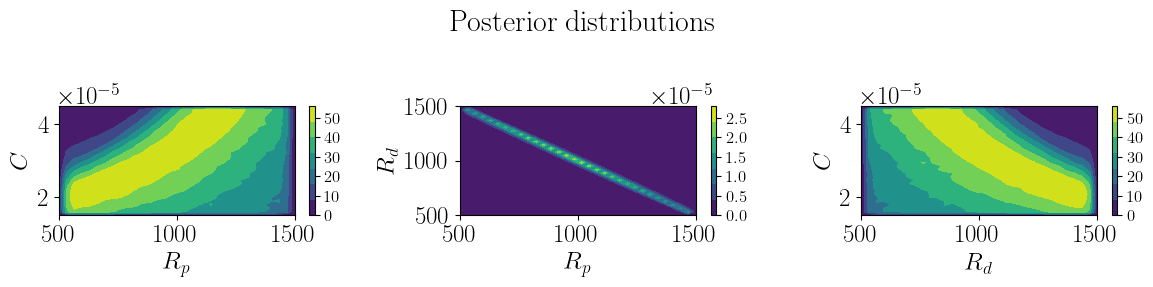

In [ ]:
#%% Plot the posterior distributions for the marginal distributions along 2 dims

# Rp, Rd, C --> Rd, Rp, C

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 18
})

fig, ax = plt.subplots(1, 3, figsize=(12,3), gridspec_kw={'width_ratios': [1, 1, 1],
                                          'height_ratios': [1]})

slice_idx = 0

cbar_a = ax[0].contourf(Rp_grid, C_grid, marginal_CRp.T)
# ax[0].contour(Rp_grid, C_grid, prior_CRp.T, colors='y', linestyles='--')
ax[0].set_xlabel('$R_p$')
ax[0].set_ylabel('$C$')

cbar_b = ax[1].contourf(Rp_grid, Rd_grid, marginal_RpRd)
# ax[1].contour(Rp_grid, Rd_grid, prior_RpRd.T, colors='y', linestyles='--')
ax[1].set_xlabel('$R_p$')
ax[1].set_ylabel('$R_d$')
# ax[1].set_ylim([25000, 28000])
# ax[1].set_xlim([Rp_low, 1000])

cbar_c = ax[2].contourf(Rd_grid, C_grid, marginal_CRd.T)
# ax[2].contour(Rd_grid, C_grid, prior_CRd, colors='y', linestyles='--')
ax[2].set_xlabel('$R_d$')
ax[2].set_ylabel('$C$')
# ax[2].set_ylim([3.5e-5, 5e-5])
# ax[2].set_xlim([25000, 30000])

nbins = 6
cbar = fig.colorbar(cbar_a)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar.locator = tick_locator
cbar.update_ticks()

cbar2 = fig.colorbar(cbar_b)
cbar2.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar2.locator = tick_locator
cbar2.update_ticks()

cbar3 = fig.colorbar(cbar_c)
cbar3.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar3.locator = tick_locator
cbar3.update_ticks()

fig.suptitle('Posterior distributions')

fig.tight_layout()

In [ ]:
#%% Compute the prior distributions

# prior distribution along 2 dims
prior_CRd     = np.sum(prior, axis=0)*(Rp_grid[1]-Rp_grid[0])
prior_RpRd    = np.sum(prior, axis=2)*(C_grid[1]-C_grid[0])
prior_CRp     = np.sum(prior, axis=1)*(Rd_grid[1]-Rd_grid[0])

# prior distribution along 1 dim
prior_Rp      = np.sum(prior, axis=(1,2))*(Rd_grid[1]-Rd_grid[0])*(C_grid[1]-C_grid[0])
prior_Rd      = np.sum(prior, axis=(0,2))*(Rp_grid[1]-Rp_grid[0])*(C_grid[1]-C_grid[0])
prior_C       = np.sum(prior, axis=(0,1))*(Rp_grid[1]-Rp_grid[0])*(Rd_grid[1]-Rd_grid[0])

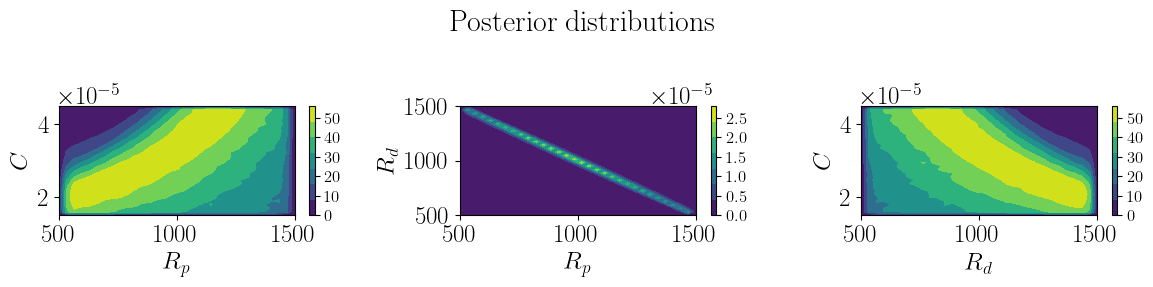

In [ ]:
#%% Plot the posterior distributions for the marginal distributions along 2 dims

# Rp, Rd, C --> Rd, Rp, C

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 18
})

fig, ax = plt.subplots(1, 3, figsize=(12,3), gridspec_kw={'width_ratios': [1, 1, 1],
                                          'height_ratios': [1]})

slice_idx = 0

cbar_a = ax[0].contourf(Rp_grid, C_grid, marginal_CRp.T)
# ax[0].contour(Rp_grid, C_grid, prior_CRp.T, colors='y', linestyles='--')
ax[0].set_xlabel('$R_p$')
ax[0].set_ylabel('$C$')

cbar_b = ax[1].contourf(Rp_grid, Rd_grid, marginal_RpRd)
# ax[1].contour(Rp_grid, Rd_grid, prior_RpRd.T, colors='y', linestyles='--')
ax[1].set_xlabel('$R_p$')
ax[1].set_ylabel('$R_d$')
# ax[1].set_ylim([25000, 28000])
# ax[1].set_xlim([Rp_low, 1000])

cbar_c = ax[2].contourf(Rd_grid, C_grid, marginal_CRd.T)
# ax[2].contour(Rd_grid, C_grid, prior_CRd, colors='y', linestyles='--')
ax[2].set_xlabel('$R_d$')
ax[2].set_ylabel('$C$')
# ax[2].set_ylim([3.5e-5, 5e-5])
# ax[2].set_xlim([25000, 30000])

nbins = 6
cbar = fig.colorbar(cbar_a)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar.locator = tick_locator
cbar.update_ticks()

cbar2 = fig.colorbar(cbar_b)
cbar2.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar2.locator = tick_locator
cbar2.update_ticks()

cbar3 = fig.colorbar(cbar_c)
cbar3.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=nbins)
cbar3.locator = tick_locator
cbar3.update_ticks()

fig.suptitle('Posterior distributions')

fig.tight_layout()

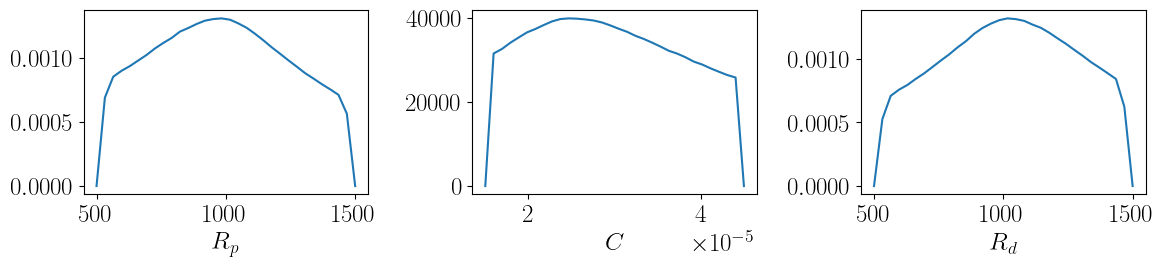

In [ ]:
# %% Plot the one dimensional marginals along 1 dim

fig, ax = plt.subplots(1, 3, figsize=(12,3), gridspec_kw={'width_ratios': [1, 1, 1],
                                          'height_ratios': [1]})

slice_idx = 0

cbar_a = ax[0].plot(Rp_grid, marginal_Rp)
# ax[0].plot(Rp_grid, prior_Rp, 'k--')
ax[0].set_xlabel('$R_p$')
# ax[0].legend(['Posterior', 'Prior'])

cbar_b = ax[1].plot(C_grid, marginal_C)
# ax[1].plot(C_grid, prior_C, 'k--')
# ax[1].legend(['Posterior', 'Prior'])
ax[1].set_xlabel('$C$')

cbar_c = ax[2].plot(Rd_grid, marginal_Rd)
# ax[2].plot(Rd_grid, prior_Rd, 'k--')
# ax[2].legend(['Posterior', 'Prior'])
ax[2].set_xlabel('$R_d$')

fig.tight_layout()

In [ ]:
epsilon

[[0.005298874189881595], [-0.5760699878171961], [0.4266634590238245]]

In [ ]:
y_obs

[[99.59172948921972], [149.20094559136368], [116.11405829961042]]

In [ ]:
p_no_noise

[99.58643061502984, 149.77701557918087, 115.68739484058659]